# 08 Sentinel-3 Algal bloom detection

## <a name="quicklink">Quick link

* [Objective](#objective)
* [Data](#data)
* [Workflow](#workflow)
* [License](#license)

## <a name="objective">Objective 

The objective of this module is to apply the methodology of the module "07 Algal bloom detection in MERIS FRS products with SNAP" on Sentinel-3 data.

## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Sentinel-3 carries three main instruments:

* The Sea and Land Surface Temperature Radiometer (SLSTR)
* The Ocean and Land Colour Instrument (OLCI)
* The Synthetic Aperture Radar Altimeter (SRAL) 

and a combination of SLSTR/OLCI data that generate ocean colour and land reflectance, land and sea temperature, ocean and land topography core products and vegetation core products

### <a name="workflow">Workflow

* Step 1: Define the Sentinel-3 product to access

In [1]:
s3path = "S3A_OL_1_EFR____20161121T042331_20161121T042631_20161121T062031_0179_011_147_2520_SVL_O_NR_002"

In [2]:
import snappy
from snappy import jpy
from snappy import GPF
from snappy import HashMap
from snappy import ProductIO
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [3]:
from snappy import jpy
from snappy import ProductIO

s3meta = "xfdumanifest.xml"
s3prd = "/workspace/data/%s/%s.SEN3/%s" % (s3path, s3path, s3meta)
reader = ProductIO.getProductReader("Sen3_SLSTRL1B_1km")
product = reader.readProductNodes(s3prd, None)

* Step 2: list the Sentinel-3 bands

In [4]:
print("Bands:   %s" % (list(product.getBandNames())))

Bands:   ['Oa01_radiance', 'Oa02_radiance', 'Oa03_radiance', 'Oa04_radiance', 'Oa05_radiance', 'Oa06_radiance', 'Oa07_radiance', 'Oa08_radiance', 'Oa09_radiance', 'Oa10_radiance', 'Oa11_radiance', 'Oa12_radiance', 'Oa13_radiance', 'Oa14_radiance', 'Oa15_radiance', 'Oa16_radiance', 'Oa17_radiance', 'Oa18_radiance', 'Oa19_radiance', 'Oa20_radiance', 'Oa21_radiance', 'altitude', 'latitude', 'longitude', 'detector_index', 'FWHM_band_1', 'FWHM_band_2', 'FWHM_band_3', 'FWHM_band_4', 'FWHM_band_5', 'FWHM_band_6', 'FWHM_band_7', 'FWHM_band_8', 'FWHM_band_9', 'FWHM_band_10', 'FWHM_band_11', 'FWHM_band_12', 'FWHM_band_13', 'FWHM_band_14', 'FWHM_band_15', 'FWHM_band_16', 'FWHM_band_17', 'FWHM_band_18', 'FWHM_band_19', 'FWHM_band_20', 'FWHM_band_21', 'frame_offset', 'lambda0_band_1', 'lambda0_band_2', 'lambda0_band_3', 'lambda0_band_4', 'lambda0_band_5', 'lambda0_band_6', 'lambda0_band_7', 'lambda0_band_8', 'lambda0_band_9', 'lambda0_band_10', 'lambda0_band_11', 'lambda0_band_12', 'lambda0_band_13

* Step 3: Reproject the data

In [5]:
import snappy
from snappy import GPF
from snappy import HashMap

HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap() 

parameters.put('crs', 'EPSG:4326') 
parameters.put('noDataValue', 0.0)

reproject = GPF.createProduct('Reproject', parameters, product)

* Step 4: Plot an RGB image  

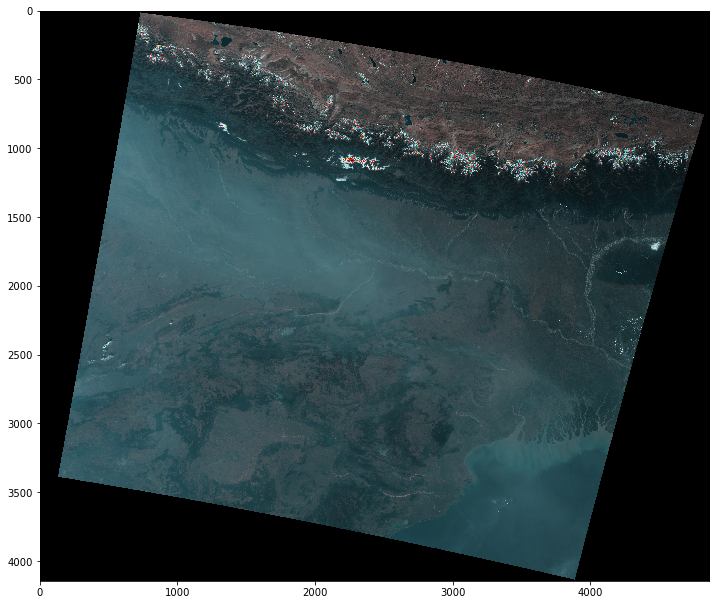

In [6]:
red_radiance = reproject.getBand('Oa08_radiance')
green_radiance = reproject.getBand('Oa05_radiance')
blue_radiance = reproject.getBand('Oa04_radiance')

w = red_radiance.getRasterWidth()
h = red_radiance.getRasterHeight()

red_radiance_data = np.zeros(w * h, np.float32)
red_radiance.readPixels(0, 0, w, h, red_radiance_data)
red_radiance_data.shape = h, w

green_radiance_data = np.zeros(w * h, np.float32)
green_radiance.readPixels(0, 0, w, h, green_radiance_data)
green_radiance_data.shape = h, w

blue_radiance_data = np.zeros(w * h, np.float32)
blue_radiance.readPixels(0, 0, w, h, blue_radiance_data)
blue_radiance_data.shape = h, w

xmax=200
red = (red_radiance_data*256/(xmax-np.amin(red_radiance_data)))
green = (green_radiance_data*256/(xmax-np.amin(green_radiance_data)))
blue = (blue_radiance_data*256/(xmax-np.amin(blue_radiance_data)))

rgb_uint8 = np.dstack((red, green, blue)).astype(np.uint8) 

width = 12
height = 12
plt.figure(figsize=(width, height))
img = Image.fromarray(rgb_uint8)
imgplot = plt.imshow(img)

Step 5: Plot a single band

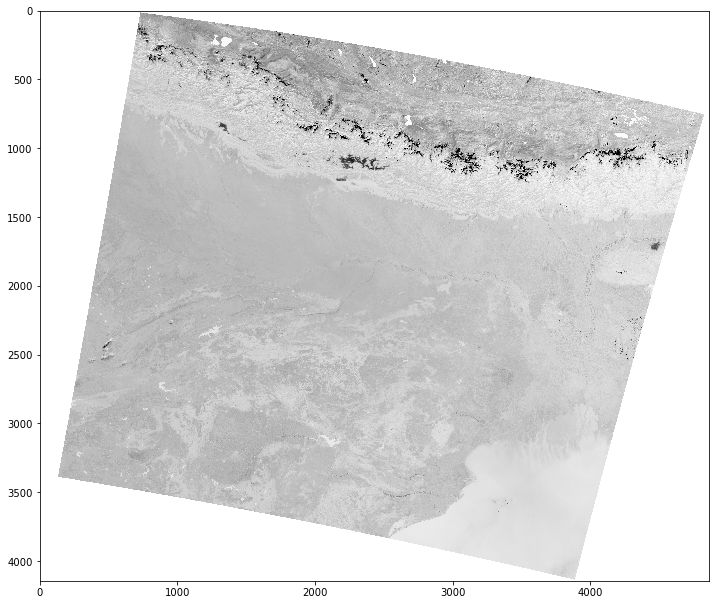

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    
    return imgplot 

plotBand(reproject, 'Oa11_radiance', 0, 200)

* Step 6: Apply the module 07 arithmetic expression

In [8]:
expression = "quality_flags_land or quality_flags_bright or quality_flags_fresh_inland_water ? 0 : Oa17_radiance>15?0:100+Oa11_radiance-(Oa10_radiance+(Oa11_radiance-Oa10_radiance)*27.524/72.570)"

In [9]:
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = jpy.get_type('java.util.HashMap')
BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBand1 = BandDescriptor()
targetBand1.name = 'band_math'
targetBand1.type = 'float32'
targetBand1.expression = expression

targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand1

parameters = HashMap()
parameters.put('targetBands', targetBands)

result = GPF.createProduct('BandMaths', parameters, reproject)

* Step 7: Plot the result

In [10]:
band1 = result.getBand('band_math')

w = band1.getRasterWidth()
h = band1.getRasterHeight()

band1_data = np.zeros(w * h, np.float32)
band1.readPixels(0, 0, w, h, band1_data)

product.dispose()

band1_data.shape = h, w

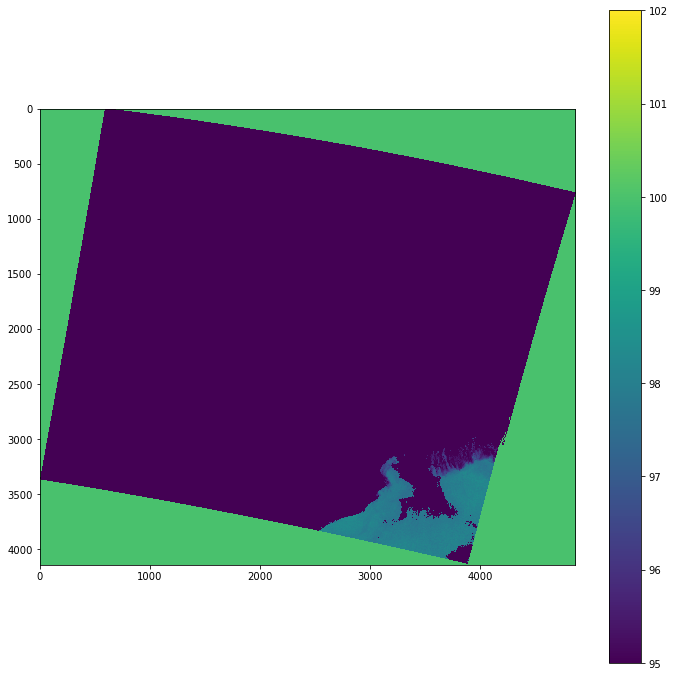

In [11]:
width = 12
height = 12
plt.figure(figsize=(width, height))
imgplot = plt.imshow(band1_data, vmin=95, vmax=102)
plt.colorbar()

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.